In [1]:
import pandas as pd
import numpy as np
import joblib 
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import  make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
def read_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    X_train = data["X_train"].copy()
    X_valid = data["X_valid"].copy()
    X_test = data["X_test"].copy()
    y_train = data["y_train"].copy()
    y_valid = data["y_valid"].copy()
    y_test = data["y_test"].copy()
    features = data['feature_selection'].copy()
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, features

In [3]:
data_path = 'Preprocessing/Final_data.pkl'
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

In [4]:
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)

Huấn luyện lại 3 mô hình *Random Forest*, *XGBoost* và *LightGBM*

Ở đây ta không quan tâm đến bước fine-tune và evaluation mà chỉ quan tâm đến ***mức đóng góp*** của từng feature cho mỗi mô hình

In [24]:
mean, std, all_scores = [], [], []

random_seed = 42

models = {
            'RFC': RandomForestClassifier(random_state=random_seed),
            'XGB': XGBClassifier(random_state=random_seed),
            'LGBM': LGBMClassifier(random_state=random_seed)
        }

for model_name, model in models.items():
    print(model_name)
    
    pl = Pipeline(
        steps=[
            ('classifier', model)
        ]
    )
    metric = make_scorer(roc_auc_score)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    scores = cross_val_score(pl, X, y, scoring=metric, cv=cv)
    print('-' * 30)

    model.fit(X_train, y_train)
    
    all_scores.append(scores)
    mean.append(np.mean(scores))
    std.append(np.std(scores))

RFC
------------------------------
XGB
------------------------------
LGBM
[LightGBM] [Info] Number of positive: 192, number of negative: 998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161345 -> initscore=-1.648258
[LightGBM] [Info] Start training from score -1.648258
[LightGBM] [Info] Number of positive: 192, number of negative: 998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161345 -> initscore=-1.648258
[

In [25]:
scores_df = pd.DataFrame()
scores_df['Mean (Accuracy Score)'] = mean
scores_df['Std'] = std
scores_df.index = models.keys()
scores_df

,Mean (Accuracy Score),Std
RFC,0.586068,0.044894
XGB,0.647772,0.051892
LGBM,0.645673,0.059259


In [26]:
# Get all features
all_features = features.index.tolist()
importance_df = pd.DataFrame()
importance_rank_df = pd.DataFrame()

### 1. Random Forest

In [27]:
forest = models['RFC']
forest_importances = forest.feature_importances_.tolist()
importance_df['Random Forest'] = forest_importances
ranks = np.argsort(-np.array(forest_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['Random Forest'] = ranks

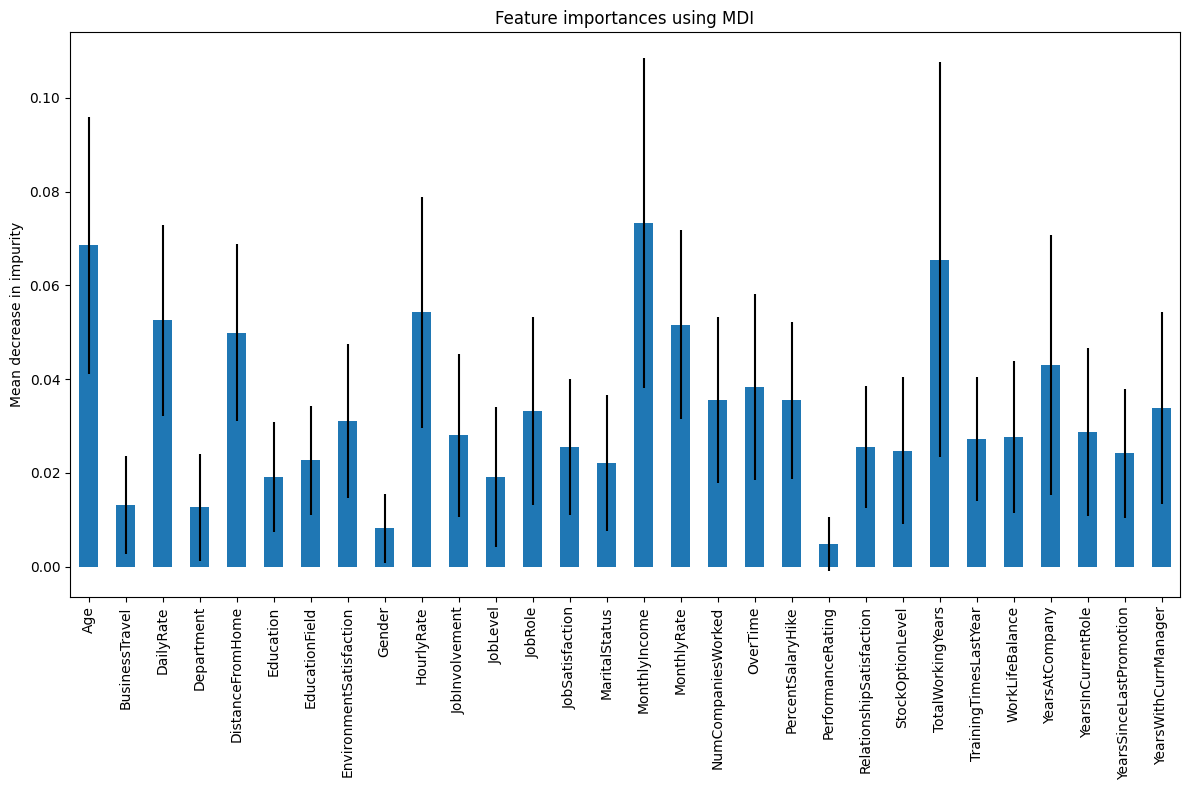

In [28]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_plot = pd.Series(forest_importances, index=all_features)

plt.figure(figsize=(12,8))
forest_plot.plot.bar(yerr=std)
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()

### 2. XGBoost

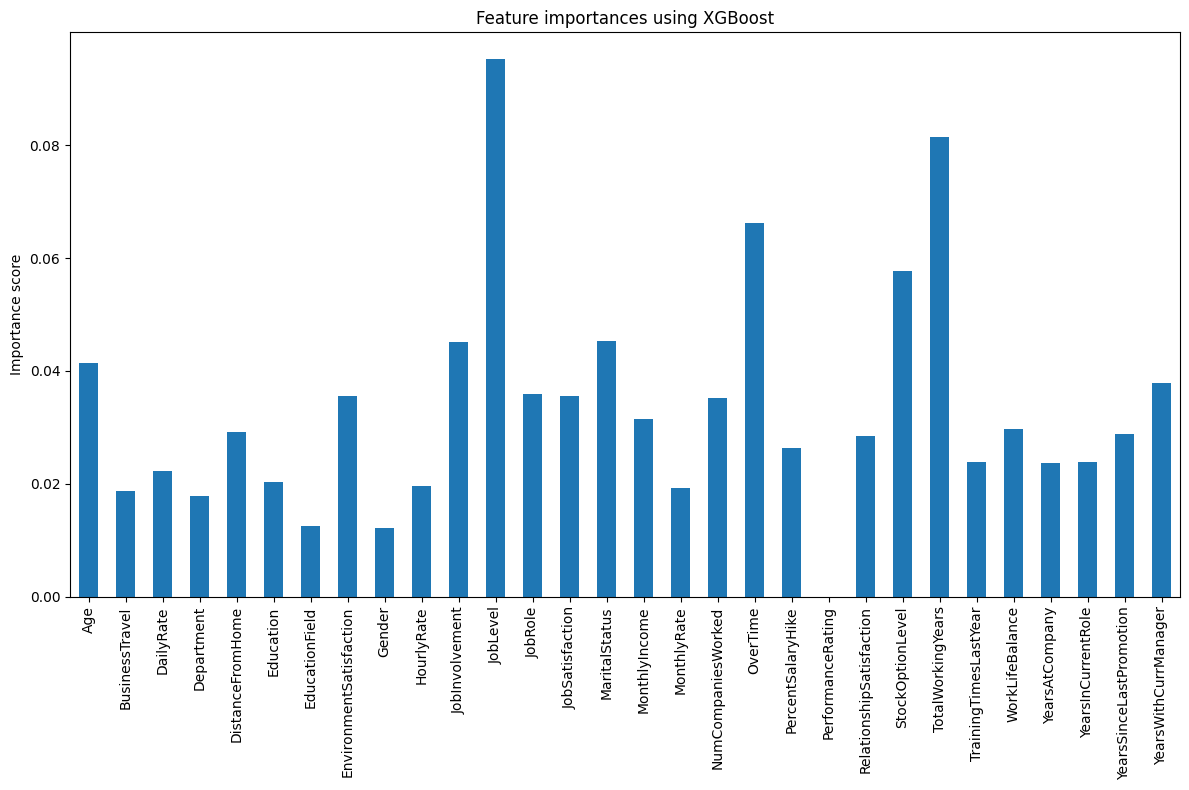

In [29]:
xgb_model = models['XGB']
xgb_importances = xgb_model.feature_importances_
importance_df['XGBoost'] = xgb_importances
ranks = np.argsort(-np.array(xgb_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['XGBoost'] = ranks

xgb_plot = pd.Series(xgb_importances, index=all_features)

plt.figure(figsize=(12,8))
xgb_plot.plot.bar()
plt.title("Feature importances using XGBoost")
plt.ylabel("Importance score")
plt.tight_layout()

### 3. CatBoost

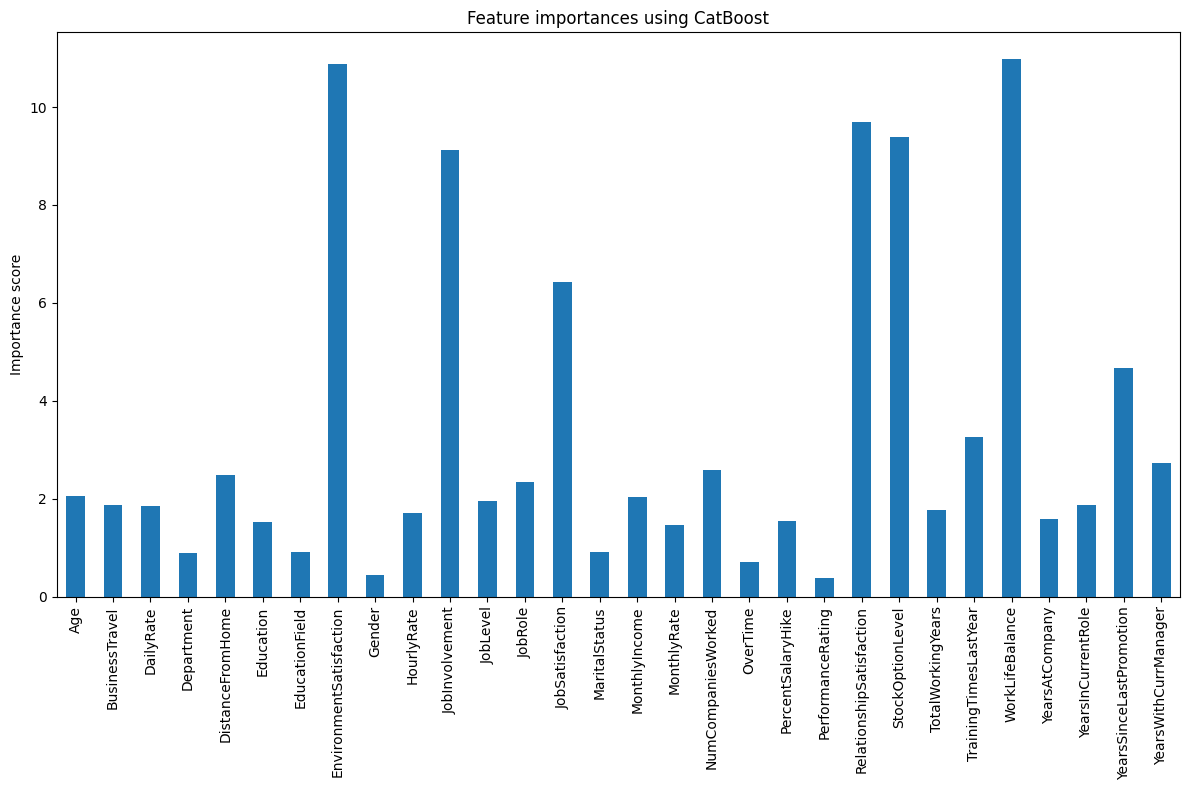

In [30]:
catboost_model = CatBoostClassifier().load_model('Models/CatBoost/catboost_model__30_features__roc_auc_objective__1744091693.cbm')
catboost_importances = catboost_model.get_feature_importance().tolist()
importance_df['CatBoost'] = catboost_importances
ranks = np.argsort(-np.array(catboost_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['CatBoost'] = ranks

catboost_plot = pd.Series(catboost_importances, index=all_features)

plt.figure(figsize=(12,8))
catboost_plot.plot.bar()
plt.title("Feature importances using CatBoost")
plt.ylabel("Importance score")
plt.tight_layout()


### 4. LightGBM

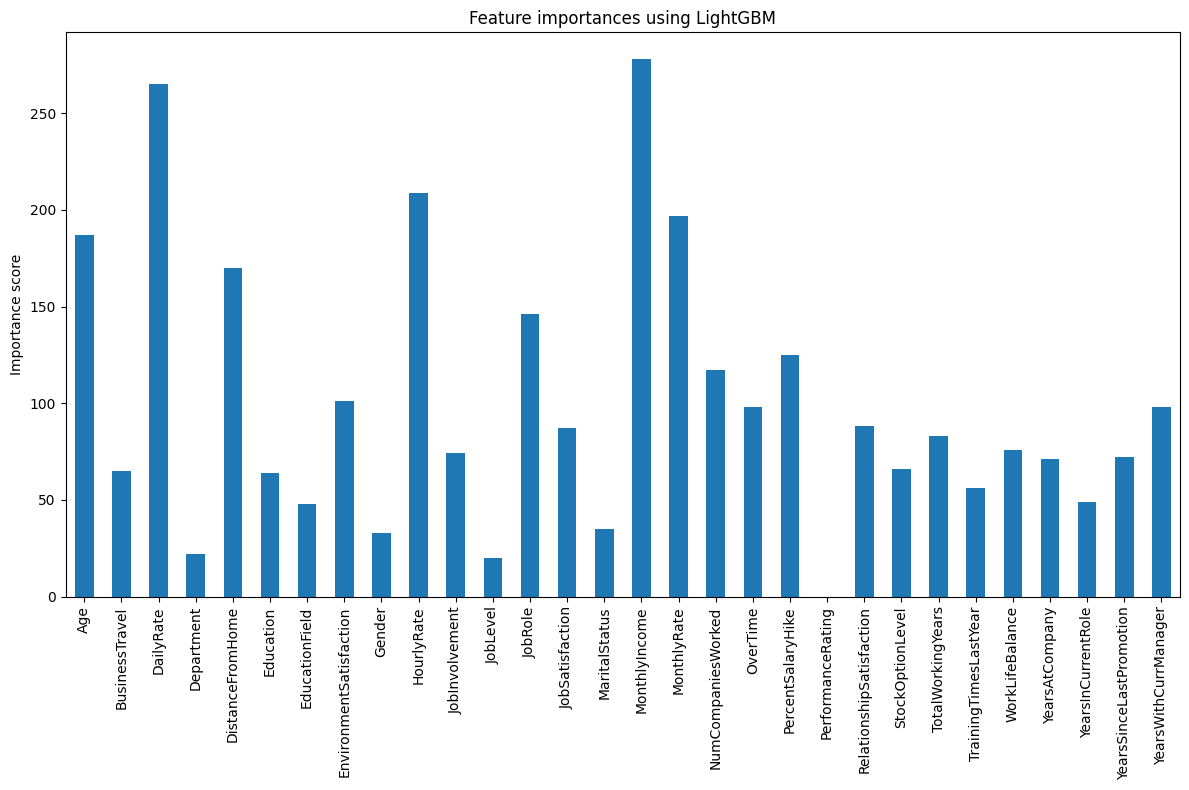

In [31]:
lgbm_model = models['LGBM']
lgbm_importances = lgbm_model.feature_importances_
importance_df['LightGBM'] = lgbm_importances
ranks = np.argsort(-np.array(lgbm_importances)) 
ranks = np.argsort(ranks) + 1  
importance_rank_df['LightGBM'] = ranks

lgbm_plot = pd.Series(lgbm_importances, index=all_features)

plt.figure(figsize=(12,8))
lgbm_plot.plot.bar()
plt.title("Feature importances using LightGBM")
plt.ylabel("Importance score")
plt.tight_layout()

### 5. Comparisions

In [32]:
importance_df.index = all_features
importance_df.sort_values('CatBoost', ascending=0)

,Random Forest,XGBoost,CatBoost,LightGBM
WorkLifeBalance,0.027653,0.029622,10.977408,76
EnvironmentSatisfaction,0.031069,0.035533,10.881763,101
RelationshipSatisfaction,0.025546,0.028464,9.703440,88
StockOptionLevel,0.024770,0.057634,9.396630,66
JobInvolvement,0.028026,0.045189,9.115569,74
JobSatisfaction,0.025494,0.035458,6.416498,87
YearsSinceLastPromotion,0.024213,0.028736,4.663651,72
TrainingTimesLastYear,0.027248,0.023910,3.258878,56
YearsWithCurrManager,0.033862,0.037781,2.727343,98
NumCompaniesWorked,0.035546,0.035230,2.580460,117


In [33]:
importance_rank_df.index = all_features
importance_rank_df['Average Rank'] = importance_rank_df.mean(axis=1)
importance_rank_df.sort_values('Average Rank', ascending=1)

,Random Forest,XGBoost,CatBoost,LightGBM,Average Rank
Age,2,7,13,5,6.75
MonthlyIncome,1,13,14,1,7.25
EnvironmentSatisfaction,14,10,2,10,9.00
TotalWorkingYears,3,2,19,15,9.75
DistanceFromHome,7,15,11,6,9.75
NumCompaniesWorked,10,12,10,9,10.25
JobRole,13,9,12,7,10.25
YearsWithCurrManager,12,8,9,12,10.25
JobInvolvement,16,6,5,17,11.00
DailyRate,5,22,18,2,11.75


### 6. Conclusions

Từ những mức đóng góp của các đặc trưng cho từng mô hình, ta có một số nhận xét như sau:

* **MonthlyIncome** và **Age** là hai đặc trưng quan trọng nhất, cho thấy đây là 2 yếu tố ảnh hưởng nhiều nhất

* **Education**, **EducationField**, **Department**, **Gender** và **PerformanceRating** là đặc trưng ít quan trọng nhất của cả 4 mô hình. Điều này cho thấy những yếu tố này không có nhiều tác động đến sự nghỉ việc hay rời bỏ công ty của nhân viên